# Проект :<br>  
### Требуется выполнить следующие действия с данными по облигациям на дату формирования данных:  
  
       

<div style="text-align: justify"><br><br> 1. Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности.Предложить графическое представление полученных групп/кластеров. (график)</div>

<div style="text-align: justify"> 2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по  купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица)</div>


### Могут быть использованы следующие поля (а также все остальные) в любых комбинациях:<br> 
<div style="text-align: justify"><br> 'SECID' - Код ценной бумаги,<br>'SHORTNAME' - Краткое наименование,<br>'NAME' Полное наименование,<br>'FACEVALUE' - Номинальная стоимость,<br>'FACEUNIT' - валюта,<br>'DURATION' - дюрация,<br>'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов,<br>'HIGH_RISK' - признак уровня риска,<br> 'COUPONFREQUENCY' – число купонов в год,<br>'COUPONDATE' - Дата выплаты купона,<br>'COUPONPERCENT' - Ставка купона, %,<br>
 'COUPONVALUE' - Сумма купона, в валюте номинала,<br>'OFFERDATE' - Дата оферты,<br>'EMITENTNAME' – наименование эмитента,<br>
'INN' – ИНН эмитента,<br>'PRICE' – текущий % от FACEVALUE,<br>'PRICE_RUB' - котировка</div>

### Пояснения:<br> 
<div style="text-align: justify">
1. Для получения текущей даты можно использовать метод datetime.date.today();<br>                                                2. Период расчета доходности рекомендуется выбирать 365 дней с текущей даты; <br>                                                3. Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ; <br>                                        4. В общем случае процентный доход при ставке НДФЛ 13% будет  Profit =(Цена_Номинальная – Цена_покупки – НКД +<br>   0.87*Купонный_доход_руб*X_лет)* 100%  /(Цена_покупки + НКД) (комиссией брокера пренебрегаем) <br>                                5. Период расчета НКД: df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется  выбирать меньше или равный 0.2.<br>
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY. <br>                 
6. Датасет содержит данные, которые нужно преобразовывать в форматы python, а также пустые и искаженные данные, с которыми нужно что-то решить.</div>

In [59]:
import pandas as pd
import requests
from datetime import datetime, date, timedelta
import io
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
from bs4 import BeautifulSoup
import re

In [60]:
bond_url = f'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [61]:
s = requests.get(bond_url).content

In [62]:
bond = pd.read_csv(io.StringIO(s.decode('cp1251')), sep=';', header=1)

In [63]:
bond.describe()

,LISTLEVEL,ISSUESIZE,IS_COLLATERAL,IS_EXTERNAL,DURATION,EVENINGSESSION,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,DAYSTOREDEMPTION,INN,LOTSIZE,LIMIT1,LIMIT2
count,2436.000000,2.676000e+03,2695.000000,2695.000000,1852.000000,2695.000000,2695.000000,2695.000000,2321.000000,2684.000000,2684.000000,2684.000000,2647.000000,2.544000e+03,2695.000000,8.780000e+02,8.780000e+02
mean,2.382594,3.226207e+08,0.141002,0.155844,844.654428,0.130241,0.184787,0.062338,3.051271,147.342027,225.896423,373.238450,1655.880620,6.080250e+09,1.447495,3.350430e+05,1.674611e+06
std,0.848098,4.167629e+09,0.348088,0.362775,682.188855,0.336631,0.388196,0.241813,2.296821,234.280267,468.546407,614.054772,1934.736987,2.940566e+09,19.430881,8.351049e+05,4.175706e+06
min,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.000000,1.000000,21.000000,1.000000,4.550000e+02,1.000000,1.700000e+01,8.500000e+01
25%,2.000000,3.232918e+05,0.000000,0.000000,359.750000,0.000000,0.000000,0.000000,2.000000,32.000000,37.000000,91.000000,596.000000,5.405830e+09,1.000000,1.000000e+05,5.000000e+05
50%,3.000000,2.459051e+06,0.000000,0.000000,723.500000,0.000000,0.000000,0.000000,2.000000,76.000000,72.000000,182.000000,1130.000000,7.707084e+09,1.000000,2.000000e+05,1.000000e+06
75%,3.000000,1.000000e+07,0.000000,0.000000,1127.250000,0.000000,0.000000,0.000000,4.000000,146.000000,153.250000,183.000000,1872.000000,7.718950e+09,1.000000,3.000000e+05,1.500000e+06
max,3.000000,9.649987e+10,1.000000,1.000000,5635.000000,1.000000,1.000000,1.000000,12.000000,4554.000000,5336.000000,7304.000000,32574.000000,9.909570e+09,1000.000000,1.200000e+07,6.000000e+07


In [64]:
bond.dtypes

SECID                      object
SHORTNAME                  object
NAME                       object
TYPENAME                   object
ISIN                       object
REGNUMBER                  object
LISTLEVEL                 float64
FACEVALUE                  object
FACEUNIT                   object
ISSUESIZE                 float64
IS_COLLATERAL               int64
IS_EXTERNAL                 int64
PRIMARY_BOARDID            object
PRIMARY_BOARD_TITLE        object
MATDATE                    object
IS_RII                     object
DURATION                  float64
ISSUEDATE                  object
EVENINGSESSION              int64
IS_QUALIFIED_INVESTORS      int64
HIGH_RISK                   int64
COUPONFREQUENCY           float64
YIELDATWAP                 object
COUPONDATE                 object
COUPONPERCENT              object
COUPONVALUE                object
COUPONDAYSPASSED          float64
COUPONDAYSREMAIN          float64
COUPONLENGTH              float64
ISSUEDATE.1   

In [65]:
bond.shape

(2695, 53)

#### Оставляем только рублевые облигации


In [66]:
bond_rub = bond.drop(bond[bond['FACEUNIT']!='RUB'].index  )                             

#### Определяем поля, содержащие Nan

In [67]:
bond_rub.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                   80
LISTLEVEL                  156
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   18
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     28
IS_RII                    2300
DURATION                   653
ISSUEDATE                  141
EVENINGSESSION               0
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            354
YIELDATWAP                1160
COUPONDATE                   5
COUPONPERCENT               50
COUPONVALUE                 54
COUPONDAYSPASSED             5
COUPONDAYSREMAIN             5
COUPONLENGTH                 5
ISSUEDATE.1                141
INITIALFACEVALUE             0
SECSUBTYPE                2209
STARTDAT

#### Количество "пустых" записей очень большое.Удалять все Nan из датафрейма не будем, чтобы не снижать объем выборки. В случае очистки bond_rub.dropna() в датасете останется ~ 20% записей от первоначального значения.
#### Удалять Nan будем только из полей, которые используются в расчетах.

#### Определяем количество записей в полях, необходимых для расчетов показателя Доходность, содержащих Nan

In [68]:
bond_rub[['COUPONPERCENT','COUPONFREQUENCY','COUPONLENGTH','COUPONDAYSPASSED', 'COUPONLENGTH']].isna().sum()

COUPONPERCENT        50
COUPONFREQUENCY     354
COUPONLENGTH          5
COUPONDAYSPASSED      5
COUPONLENGTH          5
dtype: int64

#### Выводим список наименований организаций, по которым в расчетных полях содержатся Nan. От данных записей будем очищать датафрейм, т.к. нет возможности достоверно заменить Nan на реальные значения

In [69]:
bond_rub['NAME'][pd.isnull(bond_rub['PRICE']) | pd.isnull(bond_rub['COUPONVALUE']) | pd.isnull(bond_rub['COUPONLENGTH']) | pd.isnull(bond_rub['COUPONPERCENT']) | pd.isnull(bond_rub['COUPONFREQUENCY'])]

14        "НПФ" ООО об.сер. 01
23      Волга-Спорт АО обл. 01
25         Uranium One Inc. 01
138        Финстоун ООО об. 01
152     Арчер Финанс ООО об.01
                 ...          
2662     BCS SP Plc Series 170
2672     BCS SP Plc Series 189
2675     BCS SP Plc Series 194
2686     BCS SP Plc Series 208
2692     BCS SP Plc Series 215
Name: NAME, Length: 533, dtype: object

#### Оставляем строки, не содержащие Nan в полях, которые будут использоваться в расчетах Доходности далее. 

In [70]:
bond_rub = bond_rub.dropna(subset = ['COUPONLENGTH', 'COUPONPERCENT', 'COUPONFREQUENCY','PRICE', 'COUPONVALUE'])
bond_rub = bond_rub.reset_index(drop=True)

#### Количество записей в датафрейме, которые будем использовать для анализа

In [71]:
bond_rub.shape

(1785, 53)

#### Проводим расчет накопленного купонного дохода NKD

In [72]:
bond_rub['NKD'] = bond_rub['COUPONDAYSPASSED']/bond_rub['COUPONLENGTH']

In [73]:
bond_rub[['NKD','COUPONDAYSPASSED','COUPONLENGTH']].head()

,NKD,COUPONDAYSPASSED,COUPONLENGTH
0,0.743169,136.0,183.0
1,0.576923,105.0,182.0
2,0.885870,163.0,184.0
3,0.220994,40.0,181.0
4,0.521978,95.0,182.0


#### Очистка полей, необходимых для расчетов показателя Доходности от "мусорных" символов, оставляем только цифры и точку

In [74]:
list = ['PRICE_RUB','PRICE','FACEVALUE','COUPONPERCENT','COUPONVALUE']
for i in list:
    bond_rub[i].replace(regex=True, inplace=True, to_replace=r'[^0-9,\.\-]',value=r'')
    bond_rub[i] = bond_rub[i].str.replace(',', '.').astype(float)

#### Проводим расчет накопленного купонного дохода исходя из следующих рекомендаций
Период расчета НКД: df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется выбирать меньше или равный 0.2.
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY.


In [75]:
bond_rub['COUPON_K']=bond_rub['COUPONPERCENT']/bond_rub['COUPONFREQUENCY']

In [76]:
bond_rub['NKD_02']=np.where(bond_rub['NKD']<= 0.2,bond_rub['NKD']*bond_rub['COUPON_K'],bond_rub['NKD'])

#### Проводим расчет Доходности исходя из следующих условий 
В общем случае процентный доход при ставке НДФЛ 13% будет:
Profit =(Цена_Номинальная – Цена_покупки – НКД + 0.87*Купонный_доход_руб*X_лет)*100% /(Цена_покупки + НКД)
(комиссией брокера пренебрегаем)

#### Расчет Купонный доход в рублях

In [77]:
bond_rub['COUPONE_GANE']=(bond_rub['COUPONPERCENT']*bond_rub['FACEVALUE'])/100

#### Расчет НКД в рублях 

In [78]:
bond_rub['NKD_RUB']=(bond_rub['NKD_02']*bond_rub['FACEVALUE'])/100

#### Расчет дополнительного показателя  Прибыль/убыток  в рублях , исключаем влияние котировки на доходность по ценным бумагам, по которым цена продажи меньше номинала.

In [79]:
bond_rub['PROFIT_LOSS']=np.where(bond_rub['PRICE_RUB'] > bond_rub['FACEVALUE'], bond_rub['FACEVALUE'] - bond_rub['PRICE_RUB'] - bond_rub['NKD_RUB'], 0 - bond_rub['NKD_RUB'])

In [80]:
bond_rub[['PROFIT_LOSS','PRICE_RUB','FACEVALUE','NKD_RUB']].head()

,PROFIT_LOSS,PRICE_RUB,FACEVALUE,NKD_RUB
0,-23.151694,1015.72,1000.0,7.431694
1,-26.069231,1020.30,1000.0,5.769231
2,-81.858696,1073.00,1000.0,8.858696
3,-132.999945,1130.79,1000.0,2.209945
4,-22.969780,1017.75,1000.0,5.219780


#### Расчет купонного дохода с уплатой 13% НДФЛ в рублях

In [81]:
bond_rub['COUPONE_GANE_NDFL'] = bond_rub['COUPONE_GANE'] * 0.87

In [82]:
bond_rub[['FACEVALUE','PRICE','PRICE_RUB','NKD_02','NKD_RUB','PROFIT_LOSS','COUPONPERCENT','COUPONE_GANE','COUPONE_GANE_NDFL']].head()

,FACEVALUE,PRICE,PRICE_RUB,NKD_02,NKD_RUB,PROFIT_LOSS,COUPONPERCENT,COUPONE_GANE,COUPONE_GANE_NDFL
0,1000.0,99.32,1015.72,0.743169,7.431694,-23.151694,6.00,60.0,52.200
1,1000.0,99.75,1020.30,0.576923,5.769231,-26.069231,7.85,78.5,68.295
2,1000.0,103.93,1073.00,0.885870,8.858696,-81.858696,7.50,75.0,65.250
3,1000.0,112.04,1130.79,0.220994,2.209945,-132.999945,9.25,92.5,80.475
4,1000.0,99.71,1017.75,0.521978,5.219780,-22.969780,7.85,78.5,68.295


#### Расчет показателя Доходность в рублях

In [83]:
bond_rub['PROFIT']=np.where(bond_rub['PRICE_RUB'] > bond_rub['FACEVALUE'], (bond_rub['PROFIT_LOSS'] + bond_rub['COUPONE_GANE_NDFL']) * 100 / (bond_rub['PRICE_RUB'] + bond_rub['NKD_RUB'] ), (bond_rub['PROFIT_LOSS'] + bond_rub['COUPONE_GANE_NDFL']) * 100 / (bond_rub['FACEVALUE'] + bond_rub['NKD_RUB'] ))

In [84]:
bond_rub[['FACEVALUE','PRICE_RUB','NKD_RUB','PROFIT_LOSS','COUPONPERCENT','COUPONE_GANE_NDFL','PROFIT']].head()

,FACEVALUE,PRICE_RUB,NKD_RUB,PROFIT_LOSS,COUPONPERCENT,COUPONE_GANE_NDFL,PROFIT
0,1000.0,1015.72,7.431694,-23.151694,6.00,52.200,2.839101
1,1000.0,1020.30,5.769231,-26.069231,7.85,68.295,4.115294
2,1000.0,1073.00,8.858696,-81.858696,7.50,65.250,-1.535200
3,1000.0,1130.79,2.209945,-132.999945,9.25,80.475,-4.635918
4,1000.0,1017.75,5.219780,-22.969780,7.85,68.295,4.430749


#### Для дальнейшего анализа оставляем только доходные ценные бумаги с доходностью выше ключевой ставки ЦБ ( КeyRate) , определяем объем полученных данных

#### C сайта ЦБ РФ получаем ключевую ставку

In [85]:
def kget_kl_stavka():
    kluch_url = f'https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From='+"{}".format((datetime.today().strftime("%d.%m.%Y")))+'&UniDbQuery.To='+"{}".format((datetime.today().strftime("%d.%m.%Y")))
    s_kluch=requests.get(kluch_url).content
    soup = BeautifulSoup(str(s_kluch), 'lxml')
    soup.find_all(soup.td)
    qwe = soup.select('td:nth-child(2)')
    regex = re.compile('[^0-9,\.\-]')
    return(regex.sub('', str(qwe)))

KeyRate=float(kget_kl_stavka().replace(',', '.'))
print("Ключевая ставка ЦБ РФ - ",   KeyRate)

Ключевая ставка ЦБ РФ -  7.5


In [86]:
bond_rub = bond_rub[(bond_rub['COUPONPERCENT'] >= KeyRate) & (bond_rub['PROFIT'] > 0)]

In [87]:
bond_rub['PROFIT'].max()

14.117652068022926

#### Анализируем количество записей, оставшееся в датафрейме

In [88]:
bond_rub.shape

(904, 61)

#### Определяем количество кластеров. Для анализа отобраны столбцы, влияющие на доходность
#### При кластеризации методом k-средних количество кластеров чаще всего оценивают с помощью «метода локтя»

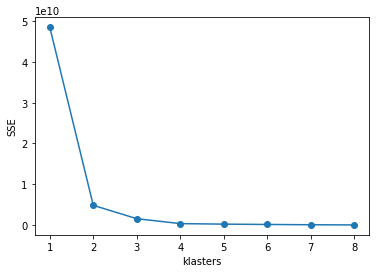

Вывод - делим на 3 кластера


In [89]:
SSE = []
for k in range(1,9):
    estimator = KMeans (n_clusters = k) 
    estimator.fit(bond_rub[['PROFIT','NKD_RUB']])
    SSE.append(estimator.inertia_)
    X = range(1,9)

plt.xlabel('klasters')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()
print('Вывод - делим на 3 кластера')


#### Выполняем кластеризацию по К-средних

In [90]:
kmeans = KMeans(n_clusters=3)
pred=kmeans.fit_predict(bond_rub[['PROFIT','NKD_RUB']])
bond_rub['ClusterID'] = pred
bond_rub.ClusterID.value_counts(normalize=False)

0    890
1      9
2      5
Name: ClusterID, dtype: int64

#### Среднее значение доходности для каждого из кластеров

In [91]:
print((bond_rub['PROFIT'].iloc[np.where(bond_rub.ClusterID==0)]).mean())
print((bond_rub['PROFIT'].iloc[np.where(bond_rub.ClusterID==1)]).mean())
print((bond_rub['PROFIT'].iloc[np.where(bond_rub.ClusterID==2)]).mean())


5.939282468332911
4.292448512270378
5.525871162230923


#### Строим диаграмму распределения кластеров по средним значениям доходности

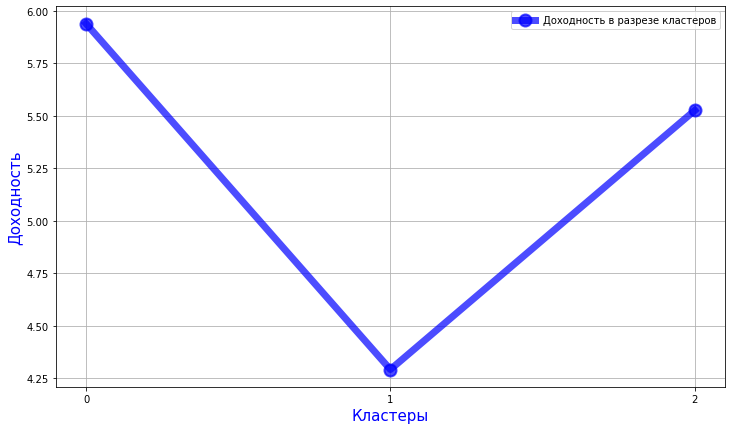

In [92]:
y = bond_rub[['PROFIT', 'ClusterID']].groupby('ClusterID').mean()
plt.figure(figsize=(12, 7))
plt.xlabel('Кластеры', fontsize=15, color='blue')
plt.ylabel('Доходность', fontsize=15, color='blue')
plt.xticks([0,1,2])
plt.plot( y, 'o-b', alpha=0.7, label="Доходность в разрезе кластеров", lw=7, mec='b', mew=2, ms=12)
# plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

#### Распределение значений в разрезе по кластерам

In [93]:
X = bond_rub[['PROFIT','NKD_RUB',]].to_numpy()
kmeans = KMeans(n_clusters=3) 
kmeans.fit(X)
print(kmeans.cluster_centers_)

[[5.93928247e+00 5.47413322e+01]
 [4.29244851e+00 6.81621430e+04]
 [5.52587116e+00 3.41588866e+04]]


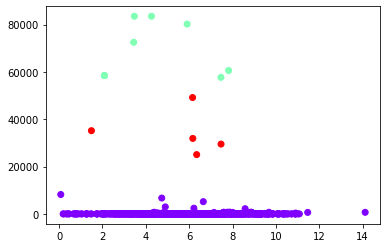

In [94]:
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')

#### Топ 5 компаний в разрезе кластеров

In [95]:
top_cl2 = bond_rub[['PROFIT', 'NAME','ClusterID']].iloc[np.where(bond_rub.ClusterID==2)]
top_cl1 = bond_rub[['PROFIT', 'NAME','ClusterID']].iloc[np.where(bond_rub.ClusterID==1)]
top_cl0 = bond_rub[['PROFIT', 'NAME','ClusterID']].iloc[np.where(bond_rub.ClusterID==0)]

#### Топ 5 компаний по кластеру 2

In [96]:
Top_5_cluster_2 = top_cl2.sort_values(by='PROFIT',ascending=False).head()
Top_5_cluster_2.head()

,PROFIT,NAME,ClusterID
1305,7.469406,Банк ВТБ ПАО СУБ-Т2-2,2
1304,6.345552,Банк ВТБ ПАО СУБ-Т2-1,2
1669,6.168024,Газпром капитал ООО 001Б-03,2
1660,6.156076,Сбербанк 002СУБ-03R,2
804,1.490298,АЛЬФА-БАНК С01-01,2


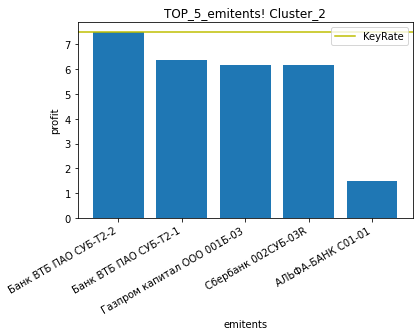

In [97]:
emitents =Top_5_cluster_2['NAME']
profit = Top_5_cluster_2['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents! Cluster_2")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()

#### Топ 5 компаний по кластеру 1

In [98]:
Top_5_cluster_1 = top_cl1.sort_values(by='PROFIT',ascending=False).head()
Top_5_cluster_1.head()

,PROFIT,NAME,ClusterID
1681,7.821043,Банк ВТБ ПАО СУБ-Т1-12,1
1680,7.464520,Банк ВТБ ПАО СУБ-Т1-11,1
949,5.904541,Банк ВТБ ПАО Т2-3,1
1558,4.261639,Банк ВТБ ПАО СУБ-Т1-5,1
1559,3.470600,Банк ВТБ ПАО СУБ-Т1-6,1


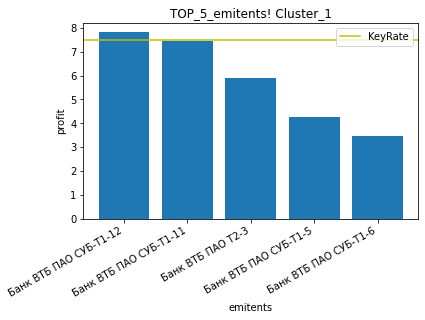

In [99]:
emitents =Top_5_cluster_1['NAME']
profit = Top_5_cluster_1['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents! Cluster_1")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()

#### Топ 5 компаний по кластеру 0

In [100]:
Top_5_cluster_0 = top_cl0.sort_values(by='PROFIT',ascending=False).head()
Top_5_cluster_0

,PROFIT,NAME,ClusterID
1760,14.117652,BCS SP Plc Series 42,0
1764,11.467340,BCS SP Plc Series 63,0
646,11.081393,ДиректЛизинг ООО БО-001P-03,0
1671,11.013865,МФК КарМани 01,0
1769,10.908905,BCS SP Plc Series 2020-8,0


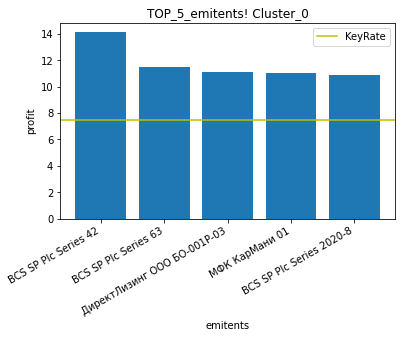

In [101]:
emitents =Top_5_cluster_0['NAME']
profit = Top_5_cluster_0['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents! Cluster_0")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()

#### Проводим расчет даты, исходя из условия по периоду 20% от текущей даты 

In [102]:
bond_rub['COUPONDAYSPASSED_0.20']= round(bond_rub['COUPONDAYSPASSED'] * 0.20)

#### Рассчитываем дату промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты

In [103]:
list_date = []
 
for index, row in bond_rub.iterrows():
    list_date.append(date.today() - timedelta(days=row['COUPONDAYSPASSED_0.20']))
bond_rub['date_NEW'] = list_date

#### Приводим  формат столбцов с датами к типу datetime

In [104]:
bond_rub['ISSUEDATE'] = pd.to_datetime(bond_rub['ISSUEDATE'])
bond_rub['date_NEW'] = pd.to_datetime(bond_rub['date_NEW'])
bond_rub['COUPONDATE'] = pd.to_datetime(bond_rub['COUPONDATE'])

In [105]:
bond_rub[['date_NEW','ISSUEDATE','COUPONDATE']].dtypes

date_NEW      datetime64[ns]
ISSUEDATE     datetime64[ns]
COUPONDATE    datetime64[ns]
dtype: object

#### Оставляем данные, удовлетворяющие условию: "COUPONDATE" и "ISSUEDATE" меньше или равны "date_NEW " и "HIGH_RISK" = 0

In [106]:
bond_rub = bond_rub[(bond_rub['COUPONDATE'] <= bond_rub['date_NEW']) & (bond_rub['ISSUEDATE'] <= bond_rub['date_NEW']) & (bond_rub['HIGH_RISK'] == 0 )]

#### PROFIT посчитан. Определяем Топ 5 эмитентов по доходности и выводим на гистограмму

In [107]:
Top_5 = bond_rub.sort_values(by='PROFIT',ascending=False).head()

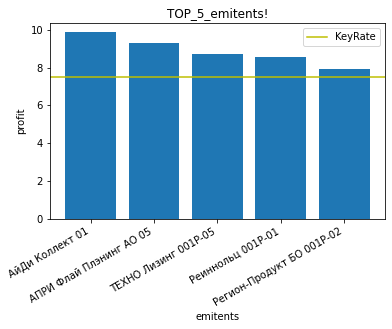

In [108]:
emitents =Top_5['NAME']
profit = Top_5['PROFIT']
fig, ax = plt.subplots()
plt.bar(emitents, profit)
plt.axhline(y=KeyRate, color = 'y')
plt.plot([KeyRate],'y',label='KeyRate')
plt.legend()
plt.title("TOP_5_emitents!")
plt.xlabel("emitents")
plt.ylabel("profit")
fig.autofmt_xdate()